In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Other Constants
N = 1000

# Create Prediction Function

In [2]:
# Define a weighting function (e.g., linear decay)
def weight_function(t, decay_rate=0.1):
    return np.exp(-decay_rate * t)

# Estimate Probability Density Function
def estimate_pdf(data_points):
    weights = weight_function(np.arange(len(data_points)))
    weights /= weights.sum()
    # Perform kernel density estimation
    kde = gaussian_kde(data_points,weights=weights)
    return kde

def predict(city):
    data = pd.read_excel("data.xlsx", sheet_name=city)

    years = np.array(data.Year[0:20]) # -> running from 2002 to 2022
    # Standardize years such that 2002 is the zeroth year.
    years = years - 2002
    # print(years)
    # print(years.shape)
    # Starting from 2024, we want to go to 2074. 2023 is Index 21, so 2024 is index 22. That means 2017 is Index 72,

    data_points = np.array(data.DeltaH[0:20])
    data_2023 = np.array(data.DeltaH[21]) # Set aside for error checking

    if (city == 'Brighton'):
        scaling = 100.0
    elif (city == 'Manchester'):
        scaling = 1000.0
    data_points = data_points / scaling
    # Create Plot to display Kernel Estimation
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    x_values = np.linspace(min(data_points), max(data_points), 1000)
    plt.hist(data_points, bins=30, density=True, alpha=0.5, label='Histogram')
    plt.plot(x_values, estimate_pdf(data_points)(x_values), label='Kernel Density Estimation')
    plt.title('Initial Kernel Density Estimation')
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.legend()

    # go to 2074
    for i in np.arange(1,54): 
        # Add the current year into years array
        curr_year = years.shape[0]
        years = np.append(years, curr_year)
        # Set previous year
        prev_year = curr_year - 1

        # Compute probability density functions and perform Monte Carlo Simulation
        kde = estimate_pdf(data_points) # Generate probability distribution
        kde_samples = kde.resample(size=N) # Sample from the pdf
        
        # Compute Adjustment Factor by comparing how the samples deviate from the previous year's value
        compare_to_prev_year = kde_samples - data_points[prev_year]

        # Find the mean deviation from the previous year's value. If the value is negative, we will subtract our adjustment factor. If positive, add it.
        multiplier = 1/scaling
        if (np.mean(compare_to_prev_year) < 0):
            multiplier = -multiplier
        adjustment_factor = np.sqrt(np.sqrt(np.sum(np.square(compare_to_prev_year))) / compare_to_prev_year.shape[0])
        adjustment_factor = adjustment_factor*multiplier

        # Randomly sample a value from the distribution and add the adjustment factor.
        curr_year_point = kde.resample(1) + adjustment_factor
        data_points = np.append(data_points, curr_year_point)

    plt.subplot(1,2,2)
    x_values = np.linspace(min(data_points), max(data_points), 1000)
    plt.hist(data_points, bins=30, density=True, alpha=0.5, label='Histogram')
    plt.plot(x_values, estimate_pdf(data_points)(x_values), label='Kernel Density Estimation')
    plt.title('Final Kernel Density Estimation')
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    data_points = data_points * scaling
    plt.figure(figsize=(8,5))
    plt.plot(years,data_points)
    plt.vlines(21, np.min(data_points), np.max(data_points), colors='red')
    plt.xlabel("Years since 2002")
    plt.ylabel("New Houses Built")
    plt.title("Annual Change in Housing Supply")

    # Evaluate Percent Error
    p_e = np.abs(data_points[21]-data_2023)/data_2023*100
    print(f'Percent Error: {p_e}')

    
    years = years + 2002
    data = {
        'Year': years,
        'DeltaH': data_points
    }
    df = pd.DataFrame(data)
    df.to_excel(f"Q1_predictions_{city}.xlsx", sheet_name=city)
    return p_e

# Brighton and Hove

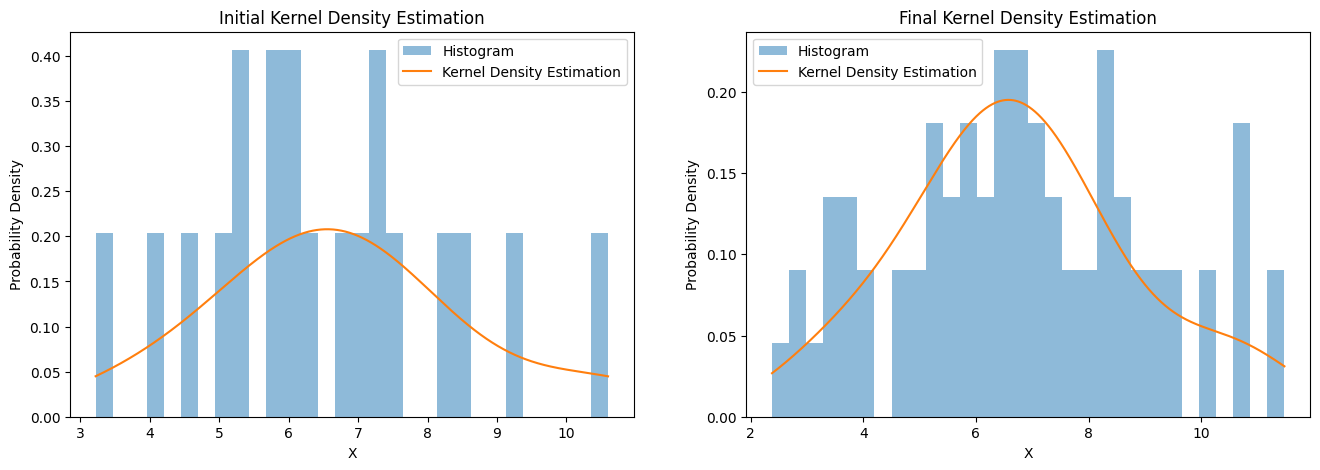

Percent Error: 8.14631630861018


8.14631630861018

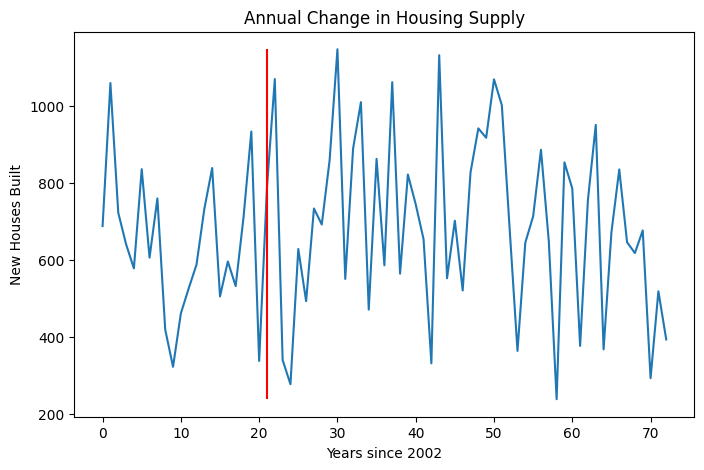

In [3]:
predict('Brighton')

# Manchester

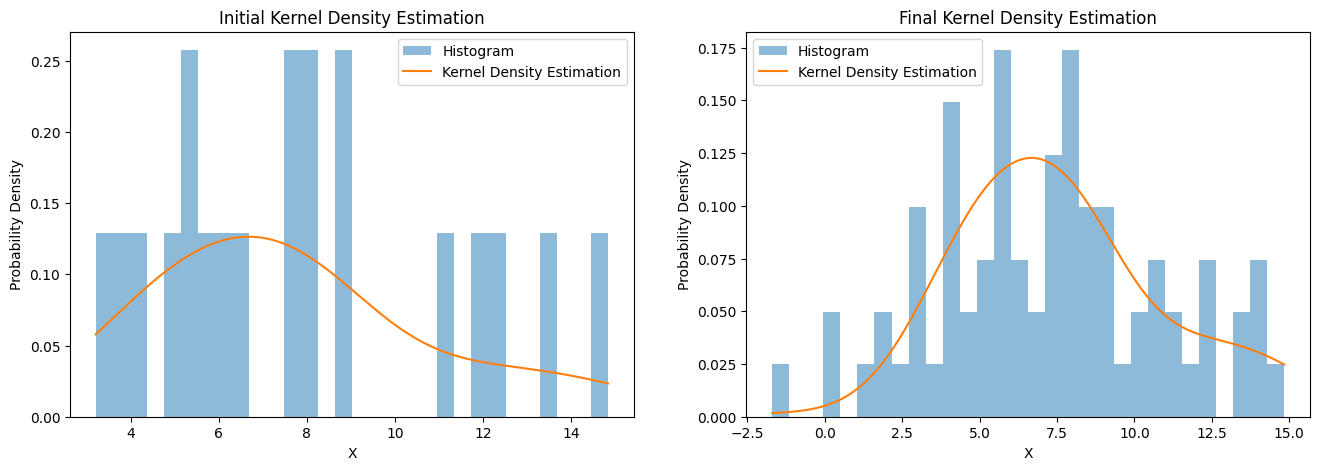

Percent Error: 3.301209243206897


3.301209243206897

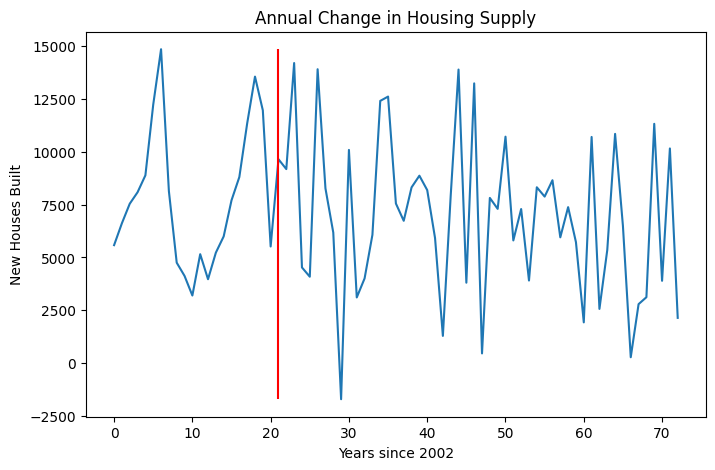

In [4]:
predict('Manchester')